# Cell type labeling of scRNA-seq data from Parkinson's disease studies

## Description

* This notebook covers functions to assing cell type labels to unsupervised clusters from two studies [Agarwal_2020](https://pubmed.ncbi.nlm.nih.gov/32826893/) and [Kamath_2022](https://pubmed.ncbi.nlm.nih.gov/35513515/).     
* Kamath et al. (2022) provided cell type labels and markers which are used to label unsupervised clusters from the two studies after batch correction.
* Requires the `adata_after_pca_and_clustering.h5ad` file produced by script `02_integration.ipynb`.

In [1]:
### External modules
import warnings
import os
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import logging
import sys
import plotly.express as px
import seaborn as sns
import numpy as np

import io
import requests

### Logs and warning settings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)s %(levelname)s:\n%(message)s")
logger = logging.getLogger(__name__)

/Users/jdime/venv_bioinfo/lib/python3.13/site-packages/anndata/utils.py:434: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


## Define inputs/outputs.

In [2]:
### base indir h5ad files
in_h5ad = os.path.expanduser('~/sc_and_spatial_parkinson/data/adata')

## Load h5ad adata

In [3]:
adata = sc.read_h5ad(os.path.join(in_h5ad, "adata_after_harmony.h5ad"))
logger.info((f"Concatenated: {adata}"))

2025-06-22 23:48:20,984 __main__ INFO:
Concatenated: AnnData object with n_obs × n_vars = 120955 × 27960
    obs: 'barcode', 'study_name', 'sample_name', 'sample_source', 'sample_organism', 'sample_tissue_region', 'donor_gender', 'donor_age_years', 'cause_of_death', 'main_cell_type', 'cell_type', 'Nurr_status', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'study_name_abv', 'umap_no_batch_corr_1', 'umap_no_batch_corr_2', 'leiden', 'umap_harmony_1', 'umap_harmony_2'
    var: 'gene-0', 'gene-1', 'feature_is_filtered-1', 'feature_name-1', 'feature_reference-1', 'feature_biotype-1', 'feature_length-1', 'feature_type-1', 'mt', 'ribo', 'n_cells_by_c

## Visualize original author cell type annotations
* Use plotly to visualize cell groups behind each other

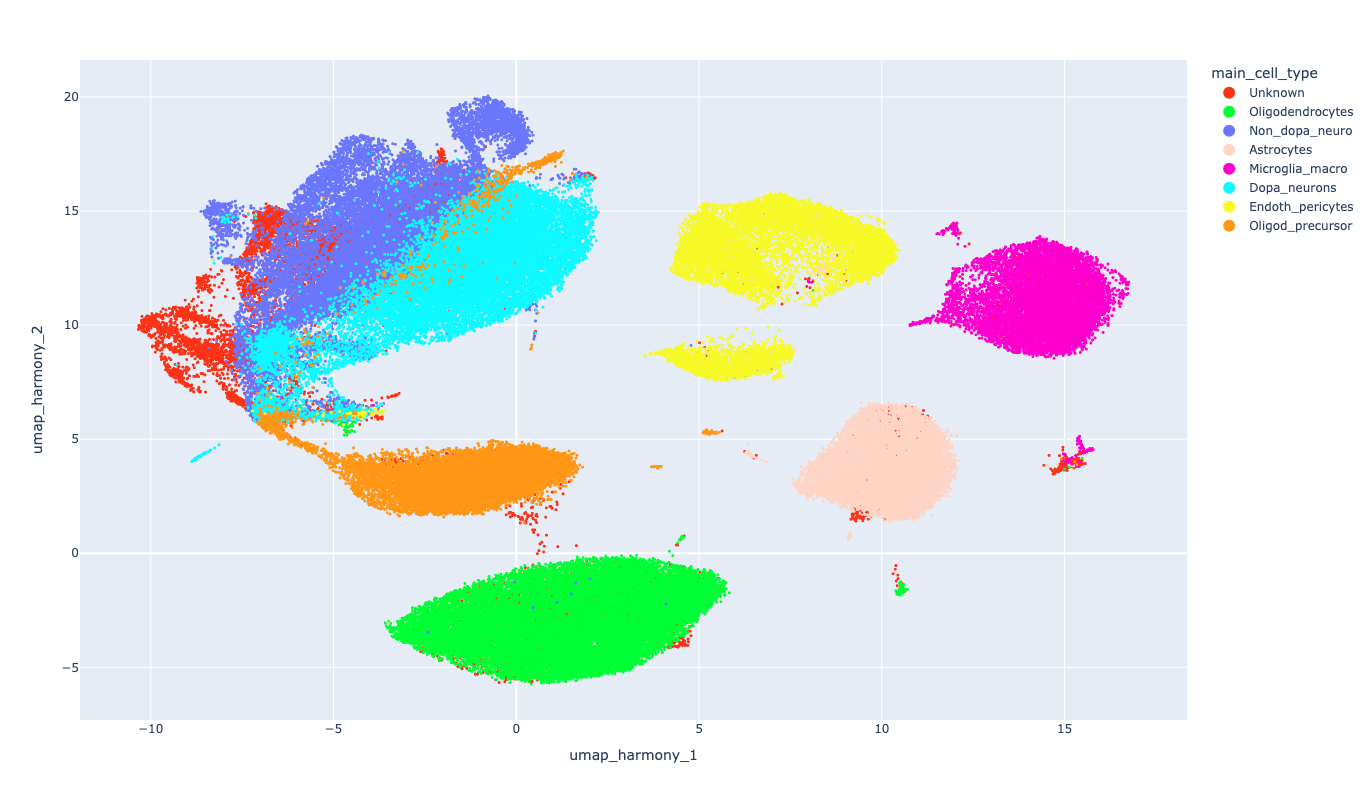

In [4]:
fig = px.scatter(
    adata.obs, x="umap_harmony_1", y="umap_harmony_2",
    color='main_cell_type',
    width=1000, height=800,
    color_discrete_sequence=px.colors.qualitative.Light24
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.show()

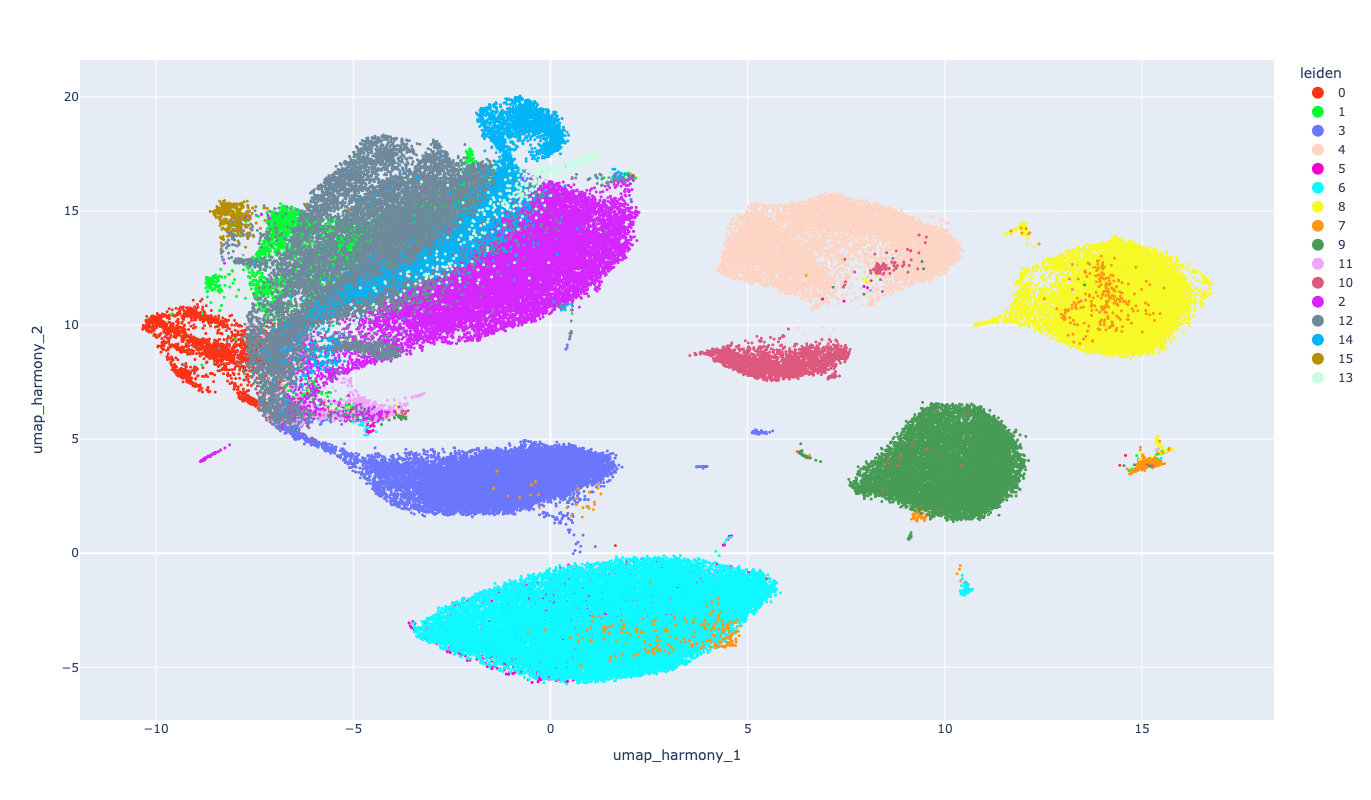

In [7]:
fig = px.scatter(
    adata.obs, x="umap_harmony_1", y="umap_harmony_2",
    color='leiden',
    width=1000, height=800,
    color_discrete_sequence=px.colors.qualitative.Light24
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.show()

## Map original author cell type annotations vs. unsuervised clusters
* Use plotly to visualize cell groups behind each other

In [9]:
leiden_v_ct = pd.crosstab(adata.obs['leiden'], adata.obs['main_cell_type'])
leiden_v_ct

main_cell_type  Astrocytes  Dopa_neurons  Endoth_pericytes  Microglia_macro  \
leiden                                                                        
0                        0             0                 0                0   
1                        0             0                 0                0   
2                        1         18343                 0                0   
3                        0             0                 1                0   
4                        8             0              8047                2   
5                        2             0                 2                0   
6                        2             0                 1                1   
7                        0             0                 0                0   
8                        1             0                 0             9997   
9                     9911             0                 0                0   
10                      71             0              1932                0   
11                       4          1390                 5                0   
12                       0           262                12                0   
13                       0             0                 0                0   
14                       0             4                 0                0   
15                       0             1                 0                0   

main_cell_type  Non_dopa_neuro  Oligod_precursor  Oligodendrocytes  Unknown  
leiden                                                                       
0                            8                 0                 0     3014  
1                           14                 0                 0     7593  
2                           27                 0                 0       44  
3                            0             13062                 2      515  
4                            0                 0                 0       48  
5                            1                 0               209     4163  
6                            8                 0             19788      114  
7                            0                 0                 0      924  
8                            0                 0                 0      270  
9                            2                 0                 0      480  
10                          28                 0                 1       15  
11                         293                 1                 0       56  
12                       15703                 6                 0       26  
13                          28               622                 0        0  
14                        3614                 0                 0        2  
15                         274                 0                 0        0

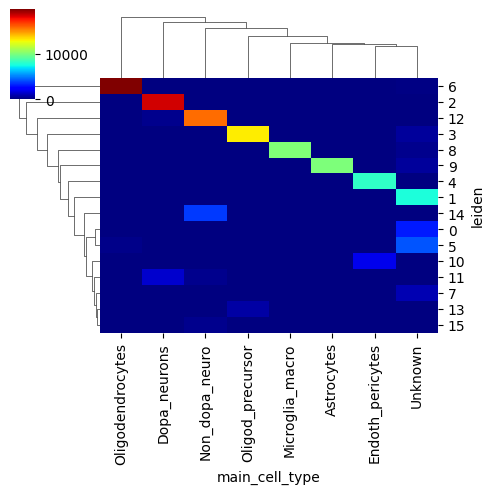

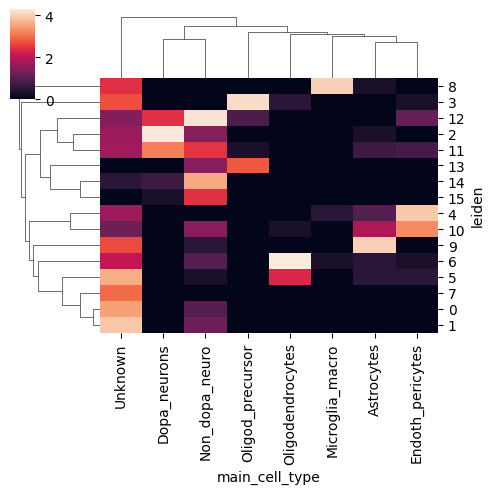

In [17]:
sns.clustermap(leiden_v_ct, cmap="jet", figsize=(5,5))
sns.clustermap(np.log10(leiden_v_ct + 1), figsize=(5,5))

## Manual annotation of clusters

In [43]:
marker_gns = ['SLC18A2', 'SLC6A3', 'TH', 'RBFOX3', 'AQP4', 'CX3CR1', 'VCAN', 'OLIG1', 'CLDN5', 'NR4A2']
marker_gn_2_ensg = {}
for gn in marker_gns:
    if gn in list(adata.var['gene-0']):
        marker_gn_2_ensg[gn] = adata.var[adata.var['gene-0'] == gn].index[0]

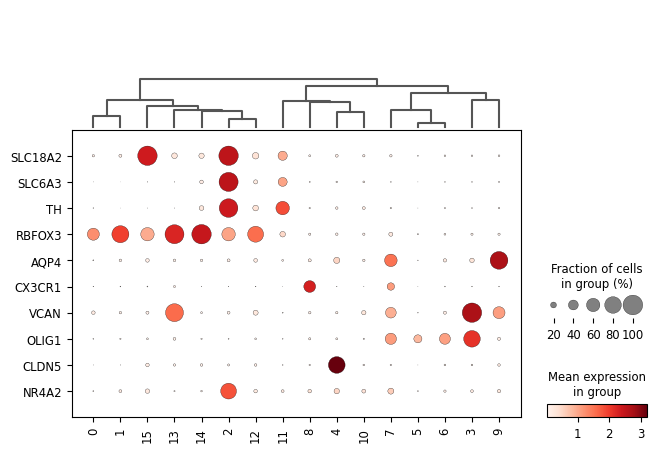

In [51]:
sc.pl.dotplot(adata, list(marker_gn_2_ensg.keys()), gene_symbols="gene-0", groupby='leiden', dendrogram=True, swap_axes=True)

2025-06-23 00:31:18,358 matplotlib.category INFO:
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 00:31:18,432 matplotlib.category INFO:
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 00:31:18,450 matplotlib.category INFO:
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 00:31:18,861 matplotlib.category INFO:
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 00:31:18,930 matplotlib.categ

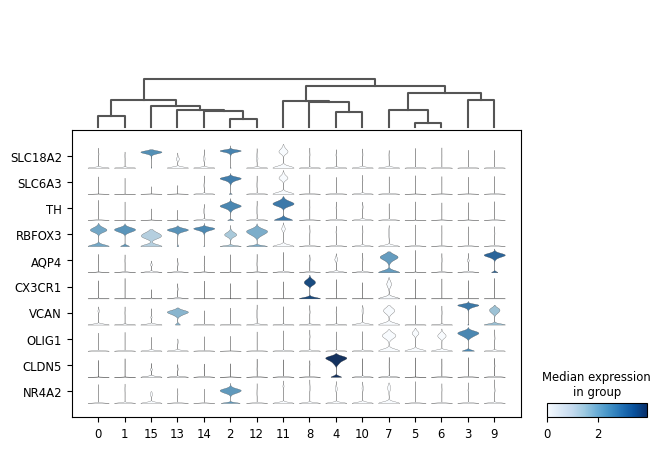

In [53]:
sc.pl.stacked_violin(adata, list(marker_gn_2_ensg.keys()), gene_symbols="gene-0", groupby='leiden', dendrogram=True, swap_axes=True)

In [69]:
leiden_manual_labels_dic = {
    '0': 'Non-dopa neurons',
    '1': 'Non-dopa neurons',
    '2': 'Dopa neurons',
    '3': 'Oligod. precursor',
    '4': 'Endoth / pericytes',
    '5': 'Oligodendrocytes',
    '6': 'Oligodendrocytes',
    '7': 'Miscellaneous',
    '8': 'Microglia / macroph.',
    '9': 'Astrocytes',
    '10': 'Endoth / pericytes',
    '11': 'Dopa neurons',
    '12': 'Non-dopa neurons',
    '13': 'Oligod. precursor',
    '14': 'Non-dopa neurons',
    '15': 'Non-dopa neurons',
}

# Gene reported by Kamath 2022 as transcription factor specific to mammalian midbrain DA neurons
NR4A2_ENSG = "ENSG00000153234"

In [73]:
adata.obs['new_cell_type'] = adata.obs.replace({"leiden": leiden_manual_labels_dic})['leiden']

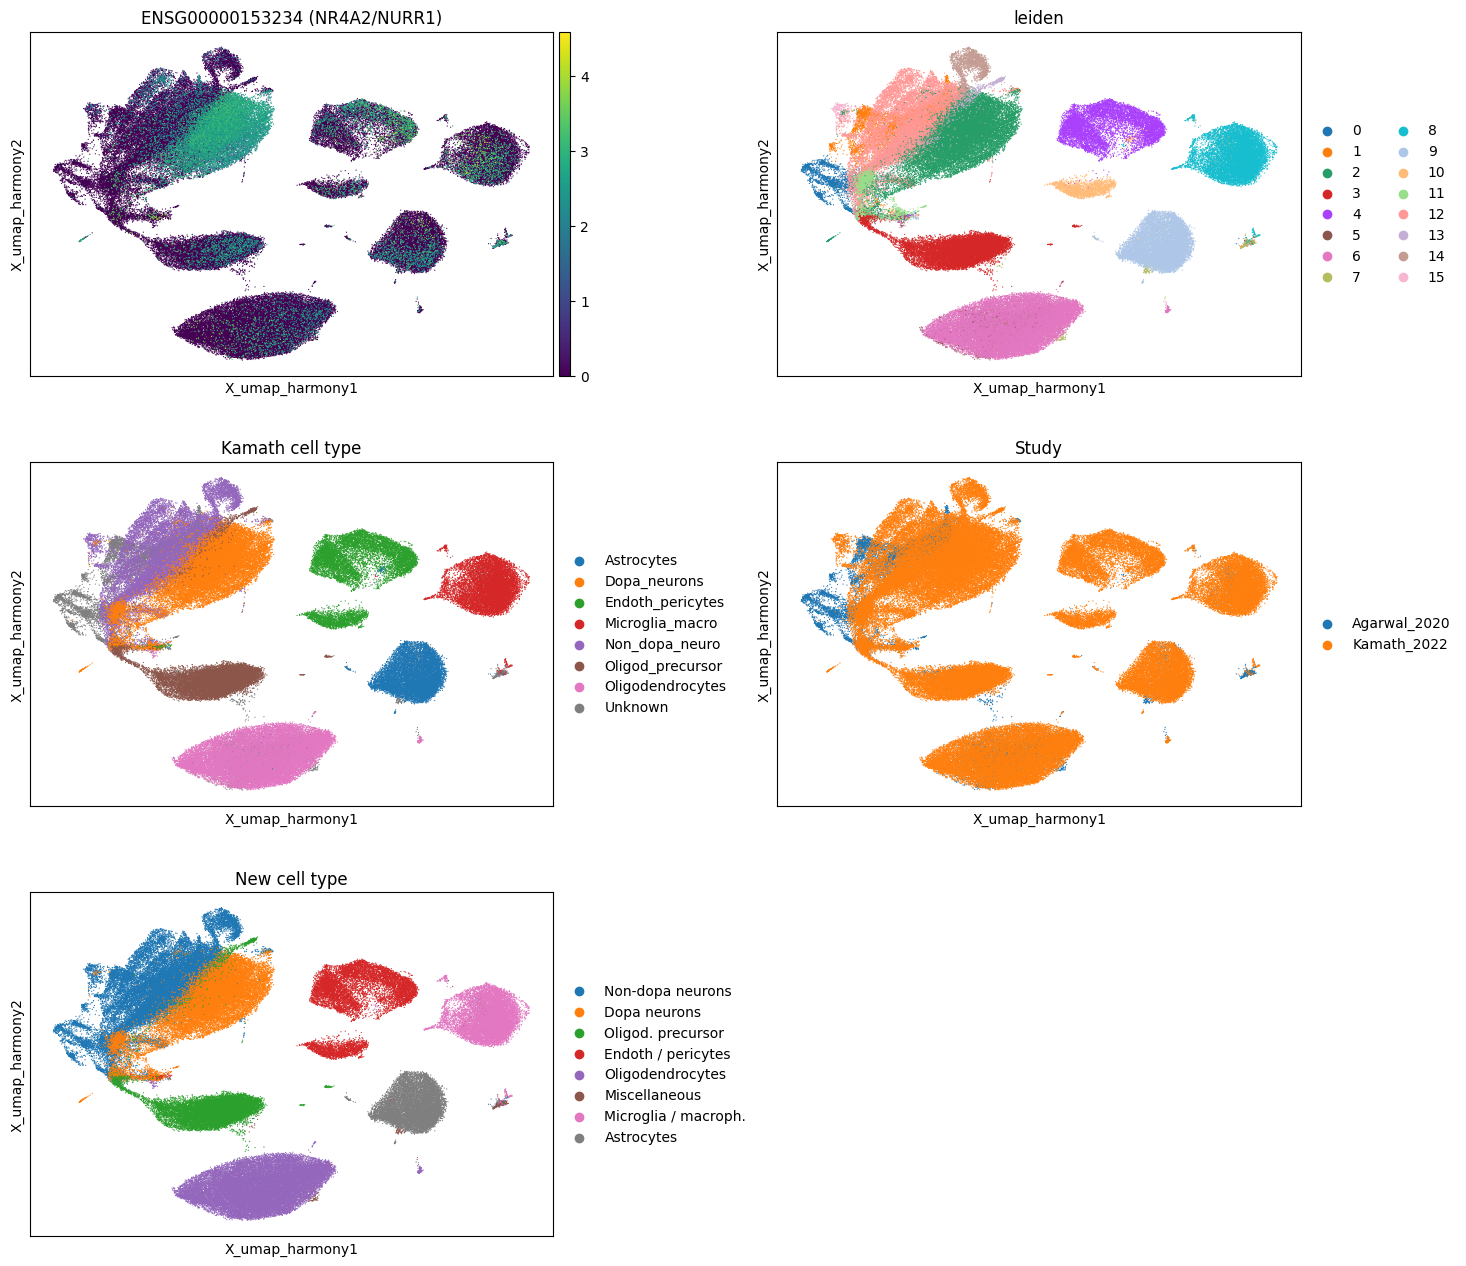

In [75]:
sc.pl.embedding(adata, basis='X_umap_harmony', color=[NR4A2_ENSG, 'leiden', 'main_cell_type', 'study_name_abv', 'new_cell_type'], 
                sort_order=True, title=[(NR4A2_ENSG + ' (NR4A2/NURR1)'), 'leiden', 'Kamath cell type', 'Study', 'New cell type'],
                size=3, ncols = 2, wspace=0.3)